In [1]:
# Copyright 2022 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Computer Vision
# Part 1: MNIST Digit Classification
해당 문서에서 우리는 MNIST 데이터 세트에서 손으로 쓴 숫자 분류를 하기 위해 CNN을 구축하고 훈련할 것이다. MNIST 데이터 세트는 60000개의 train 이미지와, 10000개의 test 이미지로 구성되며, 모두 0~9사이의 정수 이미지이다.  

In [2]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

!pip install mitdeeplearning
import mitdeeplearning as mdl

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

     |████████████████████████████████| 2.1 MB 7.7 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115442 sha256=61c652003a10d51c02b140d1414825aa4e3ca8662b7b784cfec7a524e7dddd75
  Stored in directory: /root/.cache/pip/wheels/9a/b9/4f/99b7c8c5c75355550b83e1fcfc02956fb40c35eb01e2262877
Successfully built mitdeeplearning


## 1.1 MNIST dataset
우선 데이터를 로드하고, 일부분을 열어서 확인해 보자

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

11501568/11490434 [==============================] - 0s 0us/step


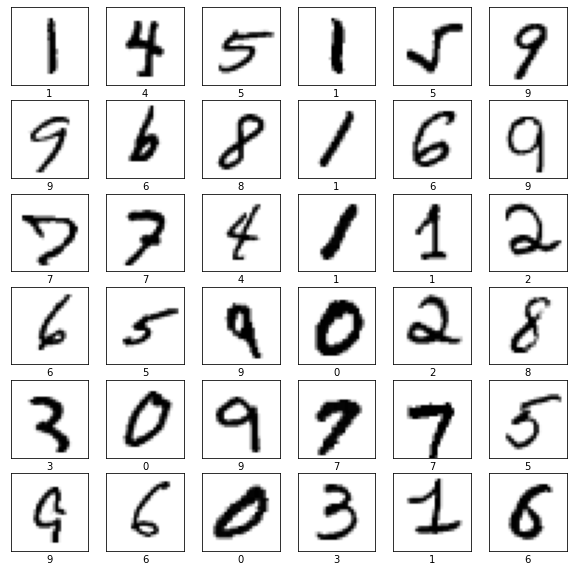

In [4]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

## 랜덤으로 어떻게 생긴 데이터인지 확인해준것! 실행할때마다 바뀐다.

# 1.2 Neural Network for Handwritten Digit Classificatio
우리는 두개의 fully connected layer를 만들고, digit classification에 적용할 것이다.
우리의 model은 궁극적으로 input이 각각의 숫자 class일 확률을 출력하게 될 것이다.




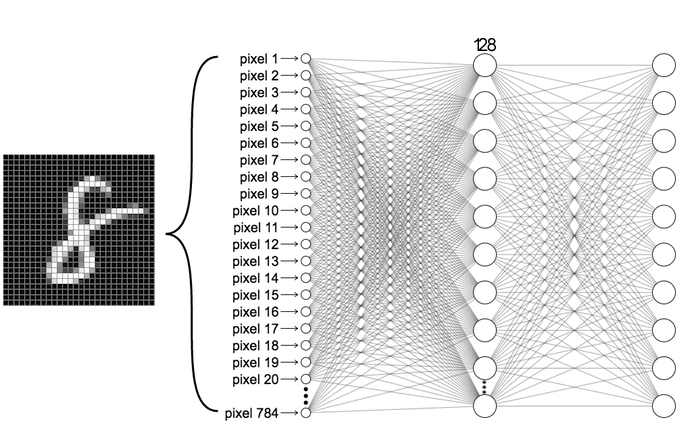

### Fully connected neural network architecture

우리는 첫번째 fully connected layer를 만들기 위해서 keras의 sequential API를 사용할 것이다. Flatten layer는 input을 펼쳐줌으로서, 모델에 입력이 가능하도록 만들어준다. 


In [5]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # First define a Flatten layer
      tf.keras.layers.Flatten(),

      # '''TODO: Define the activation function for the first fully connected (Dense) layer.'''
      tf.keras.layers.Dense(128, activation=tf.nn.relu ),
      #렐루 모델을 사용한다. 비선형성을 더해주고, 훨씬 빠르기 때문이다.
      # '''TODO: Define the second Dense layer to output the classification probabilities'''
      tf.keras.layers.Dense(10, activation=tf.nn.softmax) # Dense 의 첫번째 매개변수는 output layer의 개수가 된다.
      
  ])
  return fc_model

model = build_fc_model()

모델의 구조를 바꾸고 싶다면 반드시 필요한 모든 셀을 돌려야 한다.

tf.kreras.layer.Flatten은 이미지의 2d-array(28,28픽셀)에서 1d-array의 784 pixel로 전환시켜 준다. 

그 뒤로는 두개의 Dense layer가 존재하는데, 두개 모두 fullt-connected neural layer다. 첫번째 Dense layer는 128개의 node(혹은 뉴런)을 가지고, 두번째 layer는 합이 1인 확률 배열을 반환한다. 이때 각 노드에는 현재 이미지가 필기된 숫자 class중 하나에 속할 확률을 나타낸다. 

### Compile the model
모델을 학습시키기 이전에 우리는 약간의 추가적인 setting이 필요하며 이를 complie 단계라고 하자. 

loss function - loss function은 얼마나 정확하게 추측하고 있는지를 나타내는 값입니다. loss function을 최소화 하는 과정에서 우리는 올바른 방향으로 나아가게 됩니다.

Optimizer - optimizer는 모델이 어떤 방식으로 update 되는지를 결정합니다.

Metrics - train 및 test 단계를 모니터링 하는데 사용되는 Metric을 정의할 수 있다. 해당 에제에서는 정확하게 분류된 이미지의 일부의 정확성을 살펴보도록 하겠다. 

우리는 optimizer로 SGD를, learning rate를 0.5로 설정하고 진행하도록 하겠다. 또한 해당 예제는 카테고리 분류 문제임으로 cross entropy loss를 이용하도록 한다. 


In [6]:
'''TODO: Experiment with different optimizers and learning rates. How do these affect
    the accuracy of the trained model? Which optimizers and/or learning rates yield
    the best performance?'''
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model
우리는 batch size와 epoch를 결정해야한다. 

이전까지 우리는 GradientTape을 이용해서 최적화를 진행하였지만, copile 과정을 거친 뒤론느 우리는 fit 메소드를 이용해서 Model을 훈련할 수 있다. 

In [7]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 5

model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
938/938 [==============================] - 6s 5ms/step - loss: 0.3695 - accuracy: 0.8967
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 0.1992 - accuracy: 0.9429
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.1512 - accuracy: 0.9572
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.1233 - accuracy: 0.9644
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1035 - accuracy: 0.9705


###Evaluate accuracy on the test dataset

test_image를 모델에 입력하여 나온 결과와 test_labels를 비교하여 모델의 성능을 검증해 볼 수있다,

In [8]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = model.evaluate(test_images, test_labels) #model.evaluate 라는 메소드를 이용해서 진행

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.1102 - accuracy: 0.9681
Test accuracy: 0.9681000113487244


위의 결과를 보면, test_data에서 train_data를 사용한것 보다 정확도가 저하된 것을 확인 할 수 있다. 이는 overfitting에 의한 것으로 새로운 데이터에 대해서 성능이 조금 떨어지는 것을 의미한다. 





##1.3 Convolutional Neural Network (CNN) for handwritten digit classification
이전의 강의에서 보았듯, CNN은 computer vision의 task에서 유용하며,MINIST 데이터 에서는 거의 완벽에 가까운 정확도를 보인다. 이제 우리는 두개의 convolution layer 와 pooling layer를 가진 CNN 모델을 만들어 보도록 하겠다. 이것의 궁극적인 산출물은 0-9까지의 숫자 class를 분류하는 것이 될 것이다.


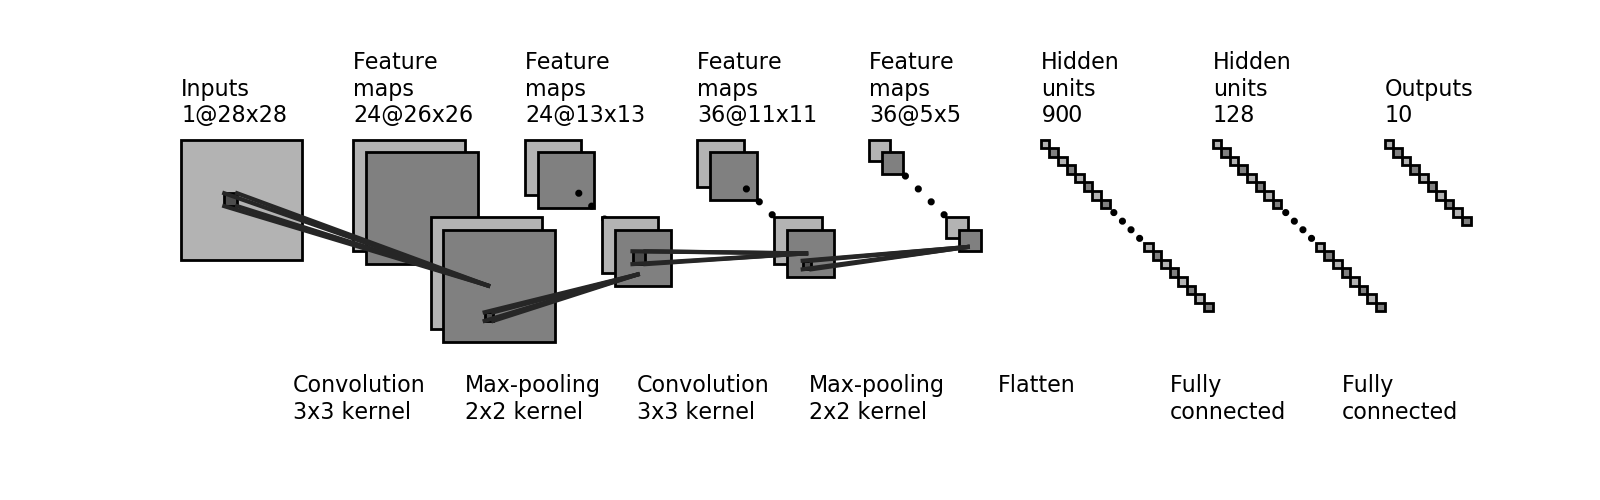

###Define the CNN model
우리는 이전에 사용한 test datasets를 사용할 것이며 이전에 사용한 fully connected layer와 유사하게 진행 할 것이다. 우리는 convolutional layer와 pooling layer를 구현하기 위해서 keras.layers.Conv2D 와 keras.layers.MaxPool2D를 이용할 것이다.


In [10]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # TODO: Define the first convolutional layer
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation = tf.nn.relu), 

        # TODO: Define the first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        # TODO: Define the second convolutional layer
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3)), # kernel이 정확하게 뭔데...? filter랑 뭐가 다른데 

        # TODO: Define the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # TODO: Define the last Dense layer to output the classification 
        # probabilities. Pay attention to the activation needed a probability
        # output
        tf.keras.layers.Dense(10, activation = tf.nn.softmax) # 앞에는 연결하고 싶은 노드의 개수, 뒤에는 사용할 함수
    ])
    
    return cnn_model
  
cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(train_images[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 24)        240       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 24)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 36)        7812      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 36)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 900)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

### Train and test the CNN model

이제 우리는 loss function, optinizer, 그리고 metrics를 complie 메소드를 이용하여 결정하고 진행할 수있다. 

학습을 진행하고, 평가해보자.

In [11]:
'''TODO: Define the compile operation with your optimizer and learning rate of choice'''
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# cnn_model.compile(optimizer='''TODO''', loss='''TODO''', metrics=['accuracy']) # TODO

In [12]:
'''TODO: Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.'''
cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
938/938 [==============================] - 7s 6ms/step - loss: 0.1829 - accuracy: 0.9467
Epoch 2/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0514 - accuracy: 0.9837
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0344 - accuracy: 0.9891
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0255 - accuracy: 0.9919
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0185 - accuracy: 0.9938


In [13]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
# test_loss, test_acc = # TODO

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.0368 - accuracy: 0.9875
Test accuracy: 0.987500011920929


###Make predictions with the CNN model
우리는 학습된 model을 가지고 이미지에 대한 예측을 진행할 수 있다. predict 기능은, input samples에 대한 예측 결괄를 생정할 것이다.

In [15]:
predictions = cnn_model.predict(test_images)
predictions[0]

array([1.6467025e-10, 4.6418198e-09, 7.0321150e-08, 1.8478780e-06,
       1.2057240e-09, 1.5792048e-11, 1.7298905e-15, 9.9999678e-01,
       2.0465714e-08, 1.2719418e-06], dtype=float32)

위를 보면, 10개의 숫자 배열을 확인 할 수있다. 이는 0~9까지 숫자 class일 확률에 대한 예측이다. 

In [18]:
'''TODO: identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
prediction = np.argmax(predictions[0])

print(prediction)

7


결과를 확인해보면, 7번 인덱스에서 확률이 가장 높으므로, 입력된 값을 7로 예측했다는 것을 알 수 있다. 정마로 정확하게 확인했는지 확인해보자

Label of this digit is: 7


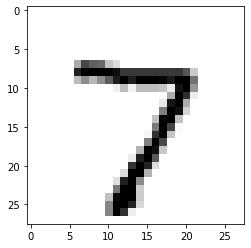

In [19]:
print("Label of this digit is:", test_labels[0])
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)

테스트 데이터 세트의 이미지를 예측 레이블과 함께 플롯하고 각 자릿수에 대한 예측 확률을 제공하는 히스토그램도 표시합니다.

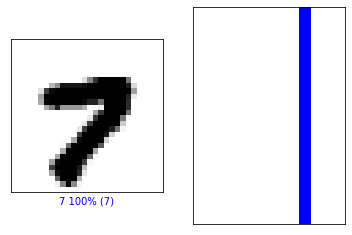

In [20]:
#@title Change the slider to look at the model's predictions! { run: "auto" }

image_index = 79 #@param {type:"slider", min:0, max:100, step:1}
plt.subplot(1,2,1)
mdl.lab2.plot_image_prediction(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
mdl.lab2.plot_value_prediction(image_index, predictions,  test_labels)

올바른 예측 레이블이 파란색이고 잘못된 예측 레이블이 회색인 여러 이미지를 예측과 함께 플롯할 수 있다. 숫자는 예측 레이블에 대한 백분율(100점 만점)을 제공합니다.

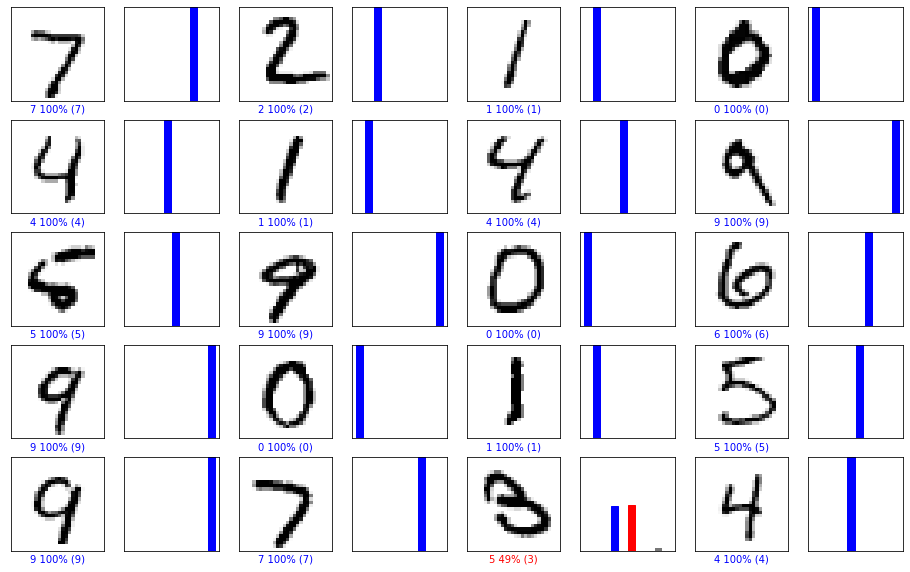

In [21]:
# Plots the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, predictions, test_labels)

##1.4 Training the model 2.0
위의 모델을 훈련시키는데 사용한 fit은 매우 직관적이고 간단하지만, 디테일한 제어를 어렵게 합니다. 이것의 대안으로 tf.GradientTape을 이용할 수 있습니다. 

이를 사용하여 cnn_model을 다시한번 만들어 보도록 합시다.

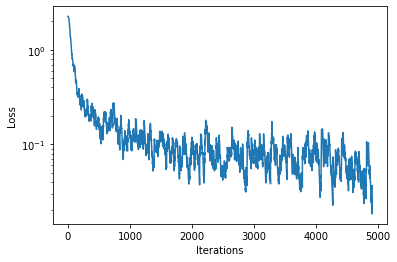

100%|██████████| 5000/5000 [01:18<00:00, 63.91it/s]


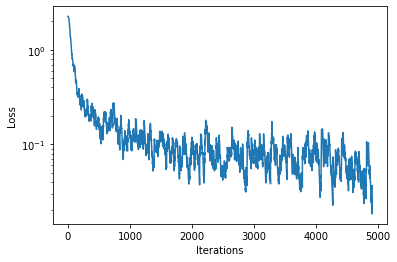

In [23]:
# Rebuild the CNN model
cnn_model = build_cnn_model()

batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2) # define our optimizer

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
  # First grab a batch of training data and convert the input images to tensors
  (images, labels) = (train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size])
  images = tf.convert_to_tensor(images, dtype=tf.float32)

  # GradientTape to record differentiation operations
  with tf.GradientTape() as tape:
    #'''TODO: feed the images into the model and obtain the predictions'''
    logits = cnn_model(images)

    #'''TODO: compute the categorical cross entropy loss
    loss_value = tf.keras.backend.sparse_categorical_crossentropy(labels, logits)

  loss_history.append(loss_value.numpy().mean()) # append the loss to the loss_history record
  plotter.plot(loss_history.get())

  # Backpropagation
  '''TODO: Use the tape to compute the gradient against all parameters in the CNN model.
      Use cnn_model.trainable_variables to access these parameters.''' 
  grads = tape.gradient(loss_value, cnn_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))

##1.5 Conclusion
실험실의 이 부분에서는 서로 다른 아키텍처(완전 연결 레이어 전용, CNN)를 사용하는 다양한 MNIST 분류기를 사용하고 서로 다른 하이퍼 파라미터가 정확도에 어떤 영향을 미치는지 실험해 볼 기회가 있었다(학습 속도 등). 실험실의 다음 부분에서는 CNN의 또 다른 응용 프로그램, 안면 감지 및 편견 문제와 같은 실제 응용 프로그램의 AI 시스템의 몇 가지 단점을 살펴봅니다
